# TP 2: segmentation and classification of PreTest signals
Topics:
-  Noisy labels
-  Imbalanced dataset
-  Feature extraction
-  Dimension reduction

In [9]:
%load_ext autoreload
%autoreload 2
from data_exploration import get_data, prepare_data
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
data = get_data()
pressure, labels = prepare_data(data)

['station_reference', 'drawdown_start_idx', 'drawdown_end_idx', 'buildup_start_idx', 'buildup_end_idx', 'drawdown_volume', 'drawdown_pressure', 'buildup_volume', 'buildup_pressure', 'buildup_label']


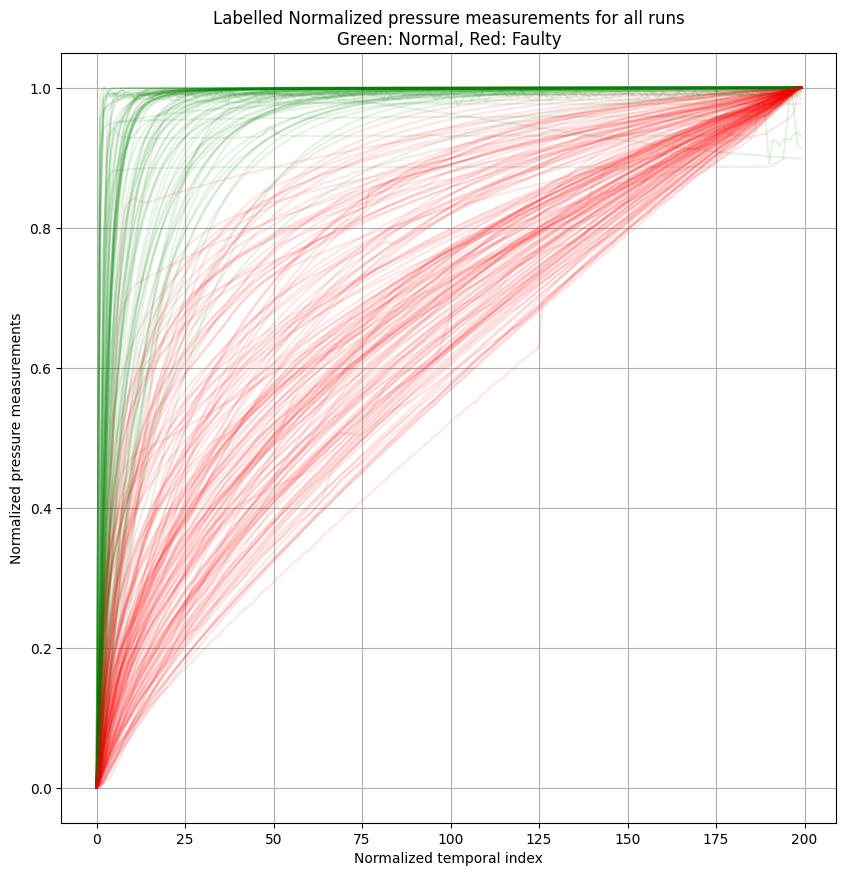

In [11]:
plt.figure(figsize=(10,10))
for press, label in zip(pressure, labels):
    plt.plot(press, "g-" if label==1 else "r-", alpha=0.1)
plt.xlabel("Normalized temporal index")
plt.ylabel("Normalized pressure measurements")
plt.title("Labelled Normalized pressure measurements for all runs\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

# Preliminary data analyzis

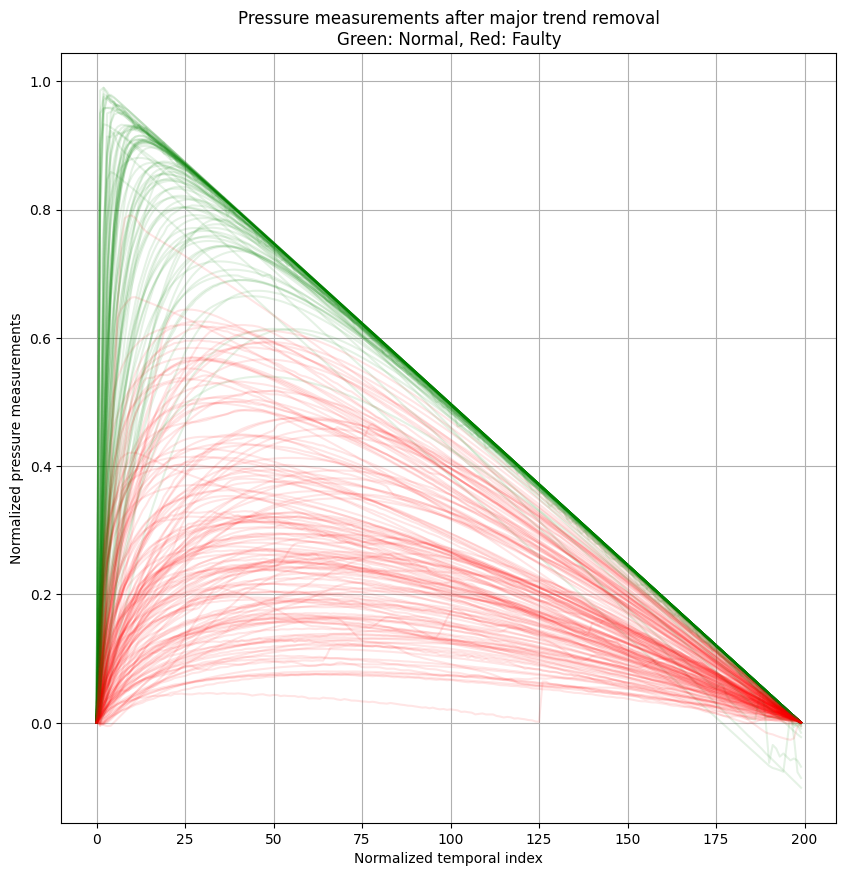

In [24]:
plt.figure(figsize=(10,10))
for press, label in zip(pressure, labels):
    plt.plot(press - np.linspace(0, 1, len(press)), "g-" if label==1 else "r-", alpha=0.1)
plt.xlabel("Normalized temporal index")
plt.ylabel("Normalized pressure measurements")
plt.title("Pressure measurements after major trend removal\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

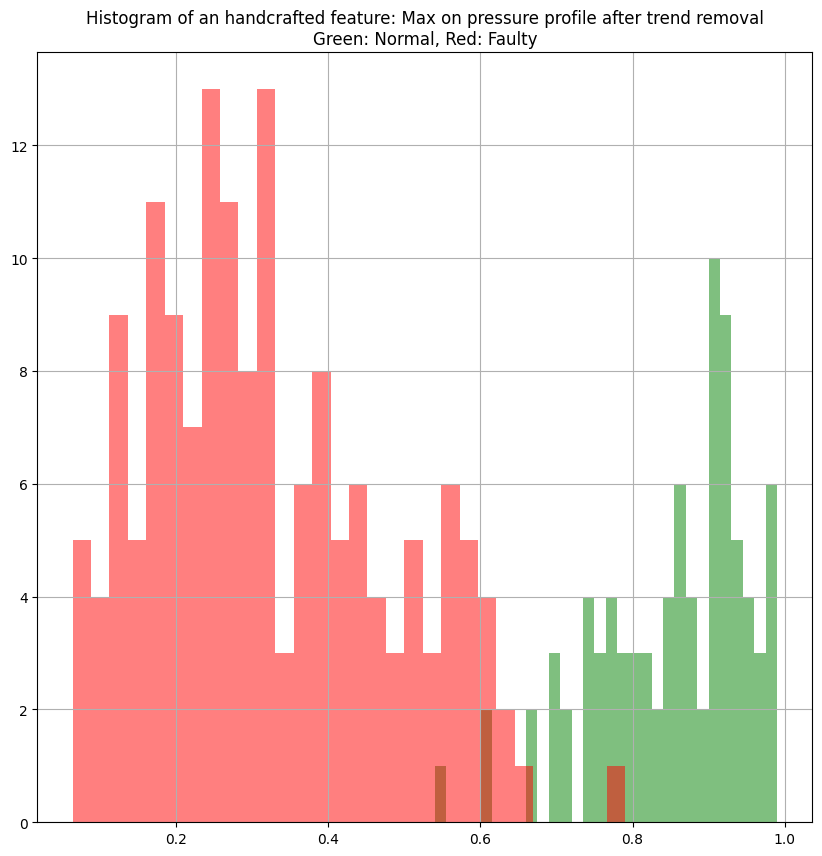

In [25]:
plt.figure(figsize=(10,10))
pos, neg = [], []
for press, label in zip(pressure, labels):
    max_feature = np.max(press - np.linspace(0, 1, len(press)))
    if label == 1:
        pos.append(max_feature)
    else:
        neg.append(max_feature)
plt.hist(pos, bins=30, alpha=0.5, label="Normal", color="green")
plt.hist(neg, bins=30, alpha=0.5, label="Faulty", color="red")
plt.title("Histogram of an handcrafted feature: Max on pressure profile after trend removal\nGreen: Normal, Red: Faulty")
plt.grid()
plt.show()

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pressure_pca = pca.fit_transform(np.array(pressure))


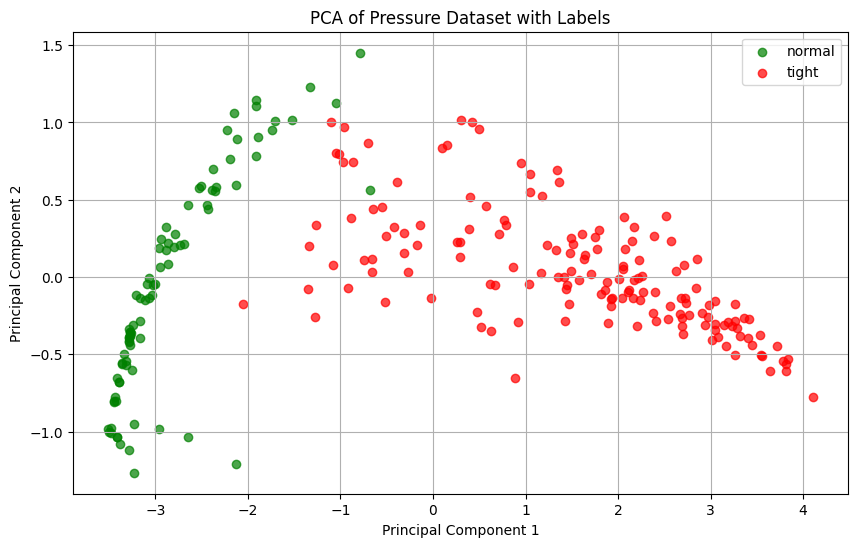

In [133]:

# Plot the first two principal components with labels
plt.figure(figsize=(10, 6))
colors = ['green', 'red']  # Colors for the labels

for i, color, label_name in zip([1, 0], colors, ["normal", "tight"]):
    indices = np.array(labels)==i
    plt.scatter(pressure_pca[indices, 0], pressure_pca[indices, 1], 
                alpha=0.7, color=color, label=f'{label_name}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Pressure Dataset with Labels')
plt.legend()
plt.grid(True)
plt.show()



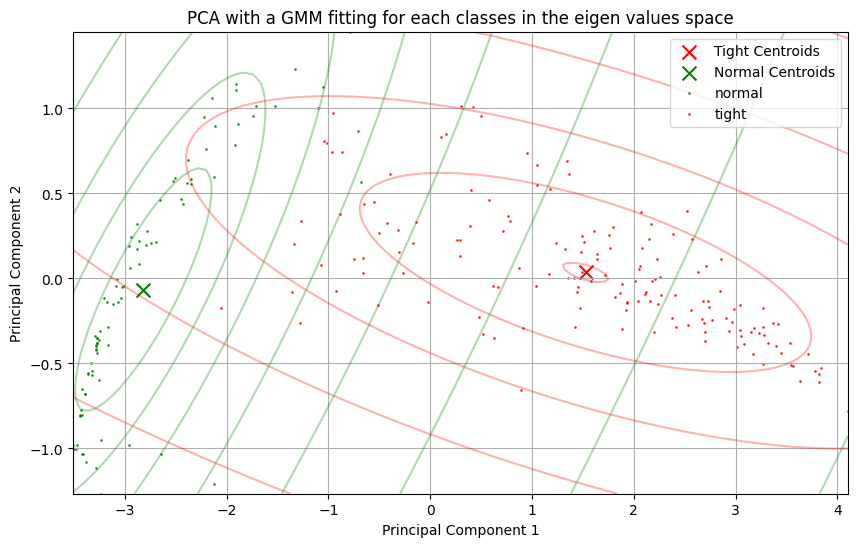

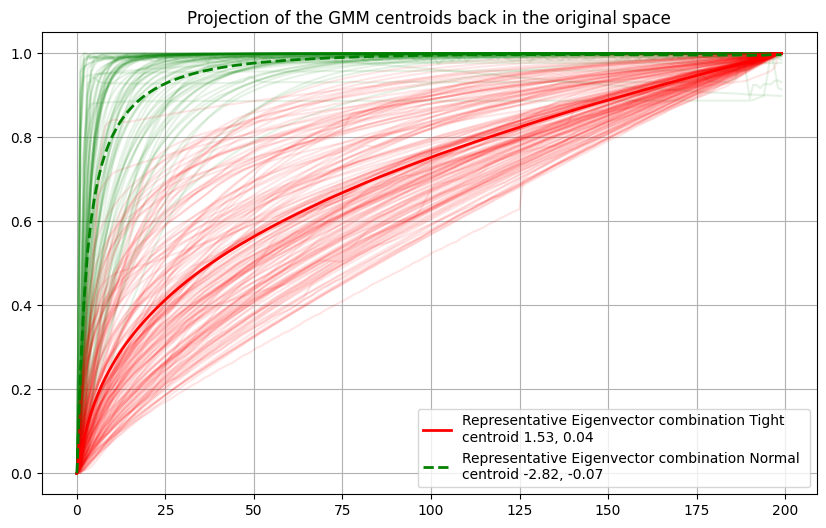

In [139]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
gmm_number_of_components = 1
pressure_pca_neg = pressure_pca[np.array(labels) == 0]
pressure_pca_pos = pressure_pca[np.array(labels) == 1]

plt.figure(figsize=(10, 6))
# Fit GMM to each class
gmm_class0 = GaussianMixture(n_components=gmm_number_of_components, covariance_type='full').fit(pressure_pca_neg)
gmm_class1 = GaussianMixture(n_components=gmm_number_of_components, covariance_type='full').fit(pressure_pca_pos)



# Plotting the GMM centroids
plt.scatter(gmm_class0.means_[:, 0], gmm_class0.means_[:, 1], color='red', marker='x', s=100, label='Tight Centroids')
plt.scatter(gmm_class1.means_[:, 0], gmm_class1.means_[:, 1], color='green', marker='x', s=100, label='Normal Centroids')


# Create a grid for plotting
x = np.linspace(np.min(pressure_pca[:, 0]), np.max(pressure_pca[:, 0]), 100)
y = np.linspace(np.min(pressure_pca[:, 1]), np.max(pressure_pca[:, 1]), 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# Calculate score samples
Z0 = -gmm_class0.score_samples(XX)
Z0 = Z0.reshape(X.shape)

Z1 = -gmm_class1.score_samples(XX)
Z1 = Z1.reshape(X.shape)

# Plotting the GMM distribution contours
plt.contour(X, Y, Z0, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10), alpha=0.3, colors='red')
plt.contour(X, Y, Z1, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10), alpha=0.3, colors='green')

for i, color, label_name in zip([1, 0], colors, ["normal", "tight"]):
    indices = np.array(labels)==i
    plt.scatter(pressure_pca[indices, 0], pressure_pca[indices, 1],  marker='o',
                s=1,
                alpha=0.7, color=color, label=f'{label_name}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA with a GMM fitting for each classes in the eigen values space')
plt.legend()
plt.grid(True)
plt.show()


# Retrieve the eigenvectors
plt.figure(figsize=(10, 6))
eigenvectors = pca.components_
first_eigenvector = eigenvectors[0]
second_eigenvector = eigenvectors[1]
pressure_array = np.array(pressure)
pressure_array = pressure_array
meanp = np.mean(pressure_array, axis=0, keepdims=True)
for i, color in zip([1, 0], colors):
    indices = np.array(labels)==i
    plt.plot(pressure_array[indices, :].T, '-', color=color, alpha=0.1)

# Plotting GMM centroids
for centroid in gmm_class0.means_:
    reproj = np.dot(centroid, eigenvectors)+meanp
    plt.plot(reproj[0, :], color='red', linewidth=2, linestyle='-', label=f'Representative Eigenvector combination Tight\ncentroid {centroid[0]:.2f}, {centroid[1]:.2f}')

for centroid in gmm_class1.means_:
    reproj = np.dot(centroid, eigenvectors)+meanp
    plt.plot(reproj[0, :], color='green', linewidth=2, linestyle='--', label=f'Representative Eigenvector combination Normal \ncentroid {centroid[0]:.2f}, {centroid[1]:.2f}')

plt.legend()
plt.title('Projection of the GMM centroids back in the original space')
plt.grid(True)
plt.show()